# Dataflow

AnnData (PY) is used as the datastructure to handle the single cell data.

Anndata2ri is used to convert AnnData, python object, to SingleCellExperiment object, R object, which can be processed by Seurat that runs in python enabled by rpy2.

Seurat is used for data normalization (`SCTransform`), and integration of different stages (`FindIntegrationAnchors` and `IntegrateData`).

Processed data will be transfered back to AnnData object in python.

Scanpy is used for data visualization due to its rich plotting functionalities.

# Setup

Setting up the above workflow in jupyter using Conda

```
# R=4.0.5 is required for compatibilities between Anndata2ri=1.0.5 and rpy2=3.4.2
# see https://github.com/theislab/anndata2ri/issues/63
conda create -n scRNA -c conda-forge r-essentials r-base=4.0
conda activate scRNA

# install seurat
# start R
install.packages("Seurat")
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install("glmGamPoi")

# Anndata, Anndata2ri, and Scanpy
pip install 'rpy2==3.4.2'
pip install anndata2ri
conda install seaborn scikit-learn statsmodels numba pytables
conda install -c conda-forge python-igraph leidenalg 
conda install -c bioconda scanpy

# jupyter
conda install ipykernel nb_black 
python -m ipykernel install --user --name scrna --display-name "scrna"
```

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from rpy2.robjects import r, globalenv
from anndata2ri.py2r import py2rpy_anndata
from scipy.sparse import coo_matrix, csr_matrix

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
# anndata2ri.activate()
# Loading the rpy2 extension enables cell magic to be used
# This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

# sc.logging.print_versions()
sc.settings.verbosity = 3

In [5]:
%%R
library(Seurat)
library(repr)
options(repr.plot.width=15, repr.plot.height=8)

R[write to console]: Attaching SeuratObject



In [6]:
def anndata_to_seurat_object(ad, r_var_name):
    """
    Convert AnnData python object to seurat object, named r_var_name in R
    """
    globalenv[r_var_name] = py2rpy_anndata(ad)
    globalenv[r_var_name] = r(f"as.Seurat({r_var_name}, counts='X', data=NULL)")
    print(r(f"repr({r_var_name})")[0])


def load_anndata(data_path, cell_meta_data=None, sep=","):
    """
    Assume count table in cell-gene orgainzation, different from R fashion; that is,
    after read by pandas, the first columns will be the cell identifiers and the header will be gene names
    """
    sc_data = pd.read_csv(data_path, sep=sep)
    adata = ad.AnnData(csr_matrix(sc_data.iloc[:, 1:]), dtype=np.float32)
    # observe dimension
    adata.obs_names = sc_data.iloc[:, 0].values
    if cell_meta_data is None:
        # need this place holder field in order for successful convertion to seurat objec
        adata.obs["Cell_ID"] = [f"Cell_{i:d}" for i in range(adata.n_obs)]
    else:
        for name, meta_data in cell_meta_data.items():
            adata.obs[name] = meta_data

    # var dimension
    adata.var_names = sc_data.columns[1:].values

    # calculate qc stats
    adata.var["mt"] = adata.var_names.str.startswith(
        "MT-"
    )  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata.obs["complexity"] = np.log10(adata.obs.n_genes_by_counts) / np.log10(
        adata.obs.total_counts
    )

    # plot to help determine cell filter conditions
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "complexity"],
        jitter=0.4,
        multi_panel=True,
    )
    # sc.pl.violin(
    #     adata,
    #     ["n_genes_by_counts", "total_counts", "pct_counts_mt", "complexity"],
    #     jitter=0.4,
    #     log=True,
    #     multi_panel=True,
    # )
    return adata

# E6.5

In [7]:
e65_data_files = {
    "E6.5_1": "singlecell_counts/E6.5/GSM3494341_Lib3-1_E6.5_counts.csv.gz",
    "E6.5_2": "singlecell_counts/E6.5/GSM3494342_Lib3-2_E6.5_counts.csv.gz",
}

## Rep 1

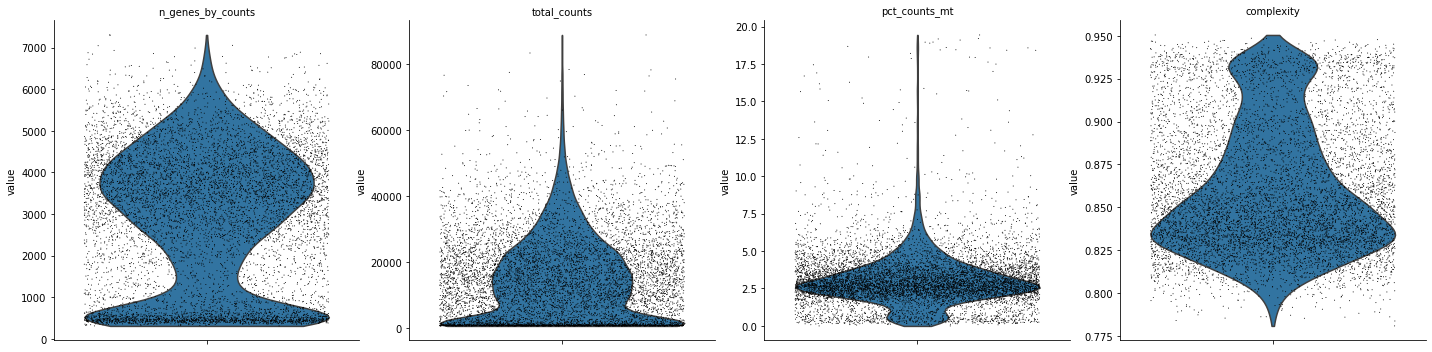

AnnData object with n_obs × n_vars = 8146 × 18636
    obs: 'Stage', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
e65_adata_1 = load_anndata(e65_data_files["E6.5_1"], {"Stage": "E6.5", "Rep": 1})
e65_adata_1

In [9]:
e65_adata_1 = e65_adata_1[
    (e65_adata_1.obs.n_genes_by_counts > 800)
    & (e65_adata_1.obs.n_genes_by_counts < 6000)
    & (e65_adata_1.obs.total_counts > 3000)
    & (e65_adata_1.obs.complexity > 0.825)
    & (e65_adata_1.obs.pct_counts_mt < 5)
]
e65_adata_1

View of AnnData object with n_obs × n_vars = 4244 × 18636
    obs: 'Stage', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Rep 2

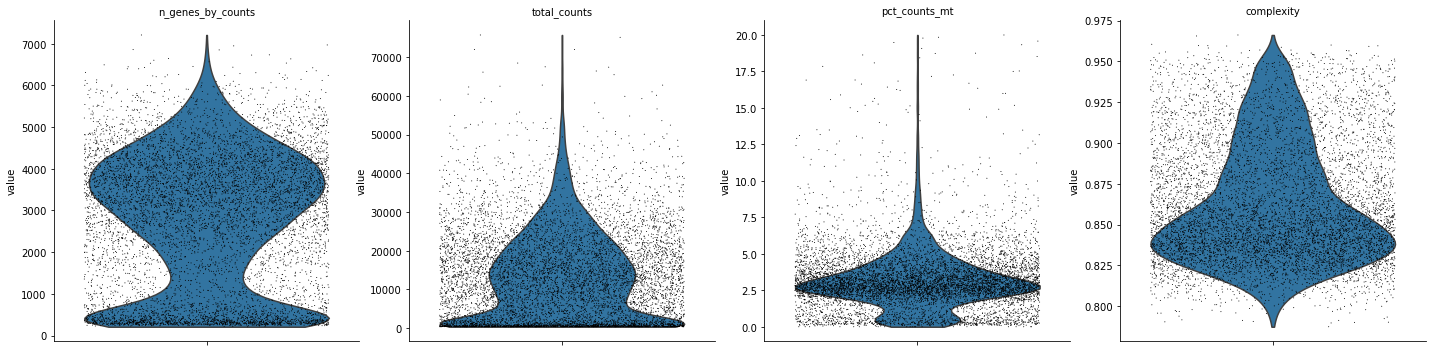

AnnData object with n_obs × n_vars = 7911 × 18358
    obs: 'Stage', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [10]:
e65_adata_2 = load_anndata(e65_data_files["E6.5_2"], {"Stage": "E6.5", "Rep": 2})
e65_adata_2

In [11]:
e65_adata_2 = e65_adata_2[
    (e65_adata_2.obs.n_genes_by_counts > 800)
    & (e65_adata_2.obs.n_genes_by_counts < 6000)
    & (e65_adata_2.obs.total_counts > 3000)
    & (e65_adata_2.obs.complexity > 0.825)
    & (e65_adata_2.obs.pct_counts_mt < 5)
]
e65_adata_2

View of AnnData object with n_obs × n_vars = 4262 × 18358
    obs: 'Stage', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
e65_adata = ad.concat([e65_adata_1, e65_adata_2], join="outer")
e65_adata.obs_names_make_unique()
e65_adata

/home/coco/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8506 × 19394
    obs: 'Stage', 'Rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'complexity'

In [13]:
anndata_to_seurat_object(e65_adata, "e65_seurat")

An object of class Seurat 
19394 features across 8506 samples within 1 assay 
Active assay: originalexp (19394 features, 0 variable features)


In [14]:
%%R
e65_seurat <- SCTransform(e65_seurat, assay="originalexp", verbose = FALSE, method = "glmGamPoi", vars.to.regress = c("Rep"))
e65_seurat

An object of class Seurat 
35507 features across 8506 samples within 2 assays 
Active assay: SCT (16113 features, 3000 variable features)
 1 other assay present: originalexp


R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: Spectral initialization failed to converge, using random initialization instead



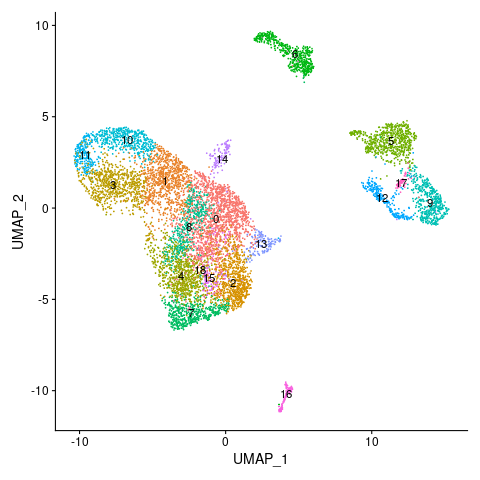

In [15]:
%%R
# These are now standard steps in the Seurat workflow for visualization and clustering
e65_seurat <- RunPCA(e65_seurat, verbose = FALSE)
e65_seurat <- RunUMAP(e65_seurat, dims = 1:30, verbose = FALSE, n.neighbors=30, min.dist=0.4, metric="correlation")

e65_seurat <- FindNeighbors(e65_seurat, dims = 1:30, verbose = FALSE)
e65_seurat <- FindClusters(e65_seurat, verbose = FALSE)
DimPlot(e65_seurat, label = TRUE) + NoLegend()

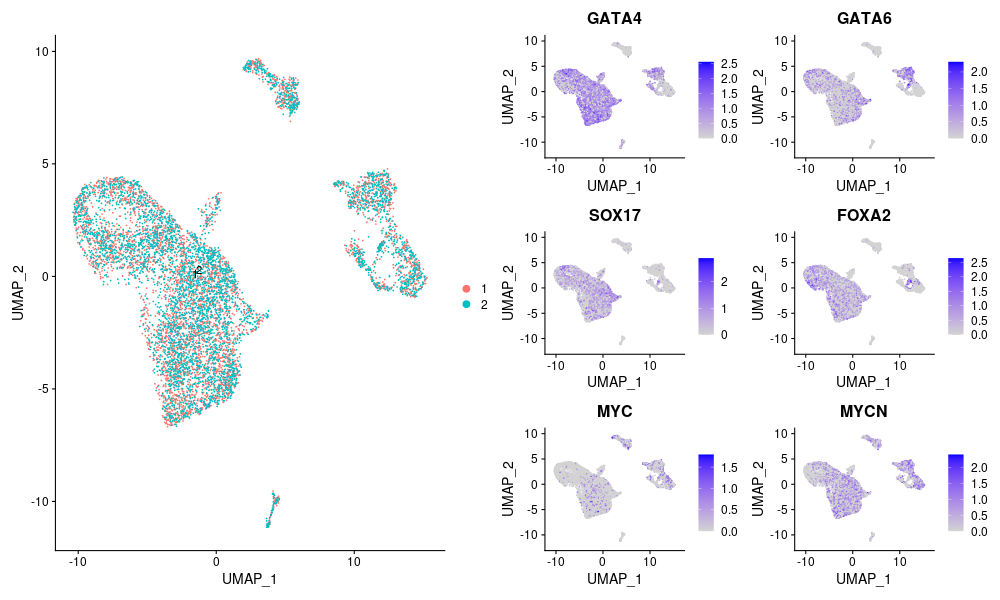

In [19]:
%%R -w 1000 -h 600
par(mfrow=c(1,2))
Idents(e65_seurat) <- "Rep"
plot1 = DimPlot(e65_seurat, label = TRUE)
plot2 = FeaturePlot(e65_seurat, features=c("GATA4", "GATA6", "SOX17", "FOXA2", "MYC","MYCN"))
plot1 + plot2

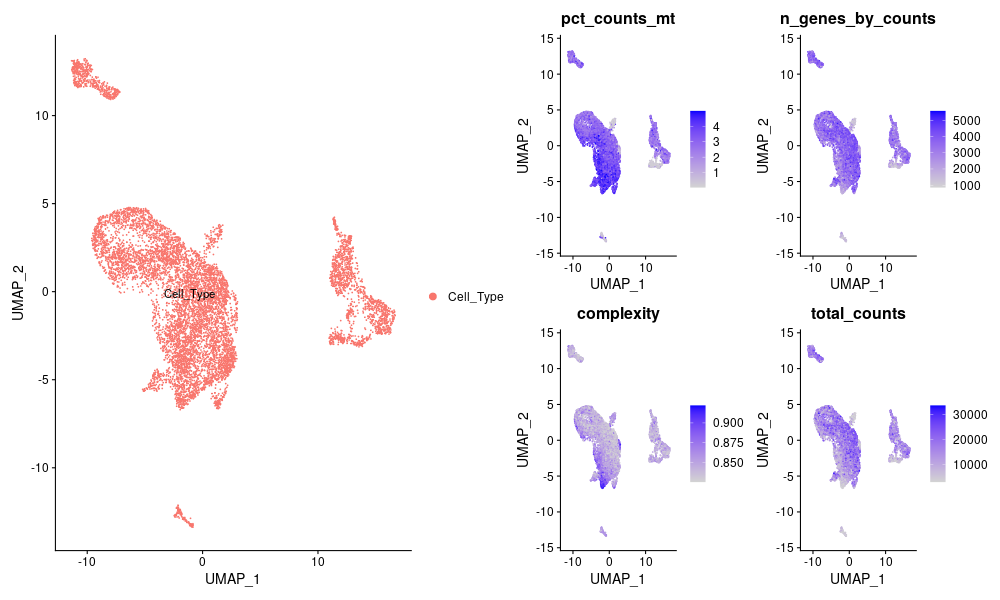

In [50]:
%%R -w 1000 -h 600
par(mfrow=c(1,2))
Idents(e65_seurat) <- "Cell_Type"
plot1 = DimPlot(e65_seurat, label = TRUE)
plot2 = FeaturePlot(e65_seurat, features=c("pct_counts_mt", "n_genes_by_counts", "complexity", "total_counts"))
plot1 + plot2

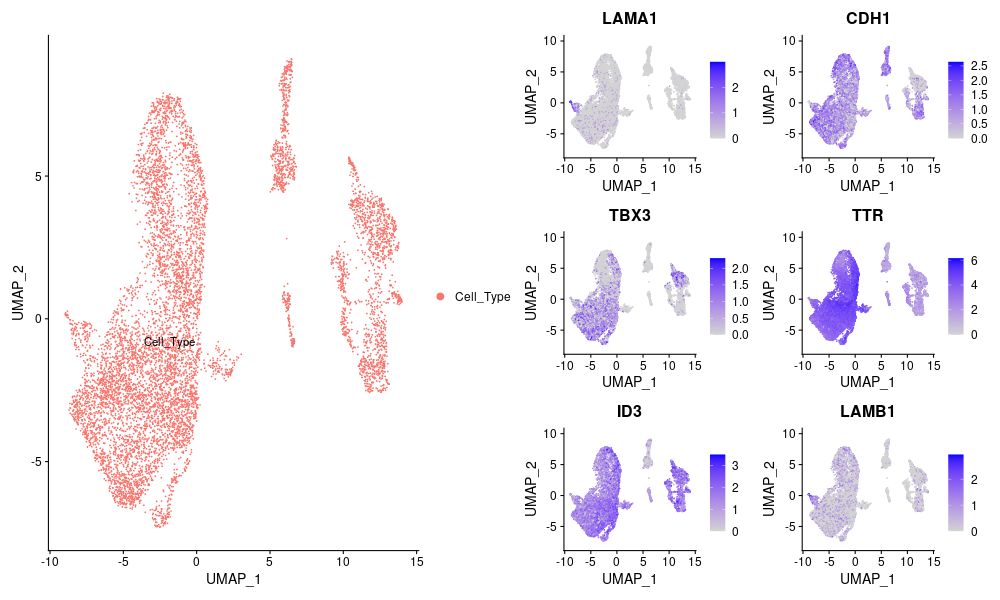

In [47]:
%%R -w 1000 -h 600
par(mfrow=c(1,2))
Idents(e65_seurat) <- "Cell_Type"
plot1 = DimPlot(e65_seurat, label = TRUE)
plot2 = FeaturePlot(e65_seurat, features=c("LAMA1", "CDH1", "TBX3", "TTR", "ID3", "LAMB1"))
plot1 + plot2

In [55]:
%%R
# cell cycle
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
e875_seurat <- CellCycleScoring(e875_seurat, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
# e875_seurat$CC.Difference <- e875_seurat$S.Score - e875_seurat$G2M.Score

R[write to console]: Warning:
R[write to console]:  The following features are not present in the object: MLF1IP, not searching for symbol synonyms

